# SchlemmerSlammer - Neural Network for recipes

### 1. Teammembers
#### Maxim Bex
research, documentation, concept, coding
#### Hannes Gelbhardt
coding, research, concept, documentation
#### York Smeddinck
documentation, concept, coding, research


### 2. Problem Description
We thought about training an AI to recommend / create recipes based on given attributes (e.g. rating, certain ingredients (include / exclude), calories, sodium, fat, FODMAP, etc.pp.). The following graphic is an entity relationship diagram for recipes, which we created to get a better understanding of the nature and complexity of our problem.

Since this would be a rather complex system to begin with, we decided to break the problem down, and start with a smaller application first. Thus we are trying to train a neural network to recommend recipe ingredients based on given ingredients.


#### General Knowledge
One of the more basic problems we face when we talking about natural language processing is that - in difference to humans - computers can just understand numbers, more specific ones and zeroes. It is not too hard to represent a language's syntax in numbers, but if we try to get meaning and context into language, humans are way better in understanding each other. The main reason for that is that humans often times have a similar context (background knowledge) so sometimes they even can communicate without words. To make this more clear, when we talk about cooking each human probably have a similar concept of preparing food in mind, but a computer just understands the word cooking out of it’s language context without actual knowing or understanding what it means.


## 3. Dataset description
### Source: https://www.kaggle.com/hugodarwood/epirecipes
The Dataset is a collection of about 21000 recipes given in a .csv and .json format, where the json file contained all information of the recipes and the .csv file is basically a list of attributes and ingredients for all recipes. We opted for using the json file, which includes more context of the ingredients (e.g. 3 evenly chopped tomatoes) compared to the csv file (e.g. 3 tomatoes), which should result in a more complex model.
### Processing the data:
Because we put our focus on the relationship of ingredients, we preprocess the data from the json format into a textfile consisting of single line listings of the recipes ingredients, excluding special characters (see variable badchars in the code below.)
#### Problems during preprocessing
The first problem was that the windows command line could not process specific characters of the dataset, which first was solved by setting the command line charset to "UTF - 8" Unfortunately we just could read and process about 700 recipes, but not all.

Our solution to this was to do all the preprocessing through a python script (see below).

Another problem were the unwanted “bad” characters (basically all symbols that are not letters) and how to exclude them.
Our solution is to check every single word for said bad characters and to replace those with an empty space.

Also we discussed whether to keep numbers (e.g. ¾) and measurement units (e.g. tbsp or cup), but we decided that our neural network would probably benefit from being able to put those aspects into context as well,so we kept them included. 


In [ ]:
#preprocessing for our interpreter of the neural network

import codecs
import json

badchars = set("0123456789(),-*\"'<>|:/%;\\")

with open('full_format_recipes.json') as json_file:  
    data = json.load(json_file)
    outFile = "./preProcessedData.txt"
    with codecs.open (outFile, "w", "utf-8-sig") as f:
        for recipe in data:
            try:
                ingredients = recipe['ingredients']
                for ingredient in ingredients:
                    for c in badchars:
                        ingredient = ingredient.replace(c,'')
                    if len(ingredient) > 1:
                        try:
                            f.write(ingredient+" ")
                        except UnicodeEncodeError:
                            print("UnicodeEncodeError")
                f.write("\n")
            except KeyError:
                print("KeyError: No ingredients listed in the recipe.")

In [1]:
#imports
import codecs
import d2l
import sys
sys.path.insert(0, '..')
import pandas as pd

import collections
import math
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import random
import sys
import collections
import time
import json
import numpy as np

# Get the interactive Tools for Matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#For the visualisation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#For Glove and Word2Vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec


Read the number of lines to get an idea how many recipes we are working with

In [2]:
#reading preprocessed data
with codecs.open('./preProcessedData.txt', 'r', 'utf-8-sig') as f:
    lines = f.readlines()
    ingredients = [st.split() for st in lines]
'# sentences: %d' % len(lines)
ingredients[:2]

[['cups',
  'lowsodium',
  'vegetable',
  'or',
  'chicken',
  'stock',
  'cup',
  'dried',
  'brown',
  'lentils',
  'cup',
  'dried',
  'French',
  'green',
  'lentils',
  'stalks',
  'celery',
  'chopped',
  'large',
  'carrot',
  'peeled',
  'and',
  'chopped',
  'sprig',
  'fresh',
  'thyme',
  'teaspoon',
  'kosher',
  'salt',
  'medium',
  'tomato',
  'cored',
  'seeded',
  'and',
  'diced',
  'small',
  'Fuji',
  'apple',
  'cored',
  'and',
  'diced',
  'tablespoon',
  'freshly',
  'squeezed',
  'lemon',
  'juice',
  'teaspoons',
  'extravirgin',
  'olive',
  'oil',
  'Freshly',
  'ground',
  'black',
  'pepper',
  'to',
  'taste',
  'sheets',
  'wholewheat',
  'lavash',
  'cut',
  'in',
  'half',
  'crosswise',
  'or',
  'inch',
  'flour',
  'tortillas',
  'pound',
  'turkey',
  'breast',
  'thinly',
  'sliced',
  'head',
  'Bibb',
  'lettuce'],
 ['cups',
  'whipping',
  'cream',
  'medium',
  'onions',
  'chopped',
  'teaspoons',
  'salt',
  'bay',
  'leaves',
  'whole',
  '

In [3]:
#rearranging all ingredients into a single array, for later comparison
ingredients_single = []
for recipe in ingredients:
    for item in recipe:
        if item not in ingredients_single:
            ingredients_single.append(item)

To get a more meaningful result, delete the tokens, which come less then 3 times in the dataset

In [4]:
#remove rare tokens
counter = collections.Counter([tk for st in ingredients for tk in st])
counter = dict(filter(lambda x: x[1] >= 3, counter.items()))

count the total number of tokens in the dataset

In [5]:
#tokencount
idx_to_token = [tk for tk, _ in counter.items()]
token_to_idx = {tk: idx for idx, tk in enumerate(idx_to_token)}
dataset = [[token_to_idx[tk] for tk in st if tk in token_to_idx]
           for st in ingredients]
num_tokens = sum([len(st) for st in dataset])
'# tokens: %d' % num_tokens

'# tokens: 915637'

To make the relationship between the most frequent words and the less frequent ones more meaningful and have a better performance, we used subsampling and print out the result of the reduced dataset

In [6]:
#subsampling
def discard(idx):
    return random.uniform(0, 1) < 1 - math.sqrt(
        1e-4 / counter[idx_to_token[idx]] * num_tokens)

subsampled_dataset = [[tk for tk in st if not discard(tk)] for st in dataset]
'# tokens: %d' % sum([len(st) for st in subsampled_dataset])

'# tokens: 256288'

For comparison we count the occurrence of the frequently used word "cup" before and after subsampling

In [7]:
#compare token frequency before and after subsampling for the word "cup"
def compare_counts(token):
    return '# %s: before=%d, after=%d' % (token, sum(
        [st.count(token_to_idx[token]) for st in dataset]), sum(
        [st.count(token_to_idx[token]) for st in subsampled_dataset]))

compare_counts('cup')

'# cup: before=43072, after=1893'

In [8]:
#defining contexts of each word in the dataset
def get_centers_and_contexts(dataset, max_window_size):
    centers, contexts = [], []
    for st in dataset:
        if len(st) < 2:
            continue
        centers += st
        for center_i in range(len(st)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, center_i - window_size),
                                 min(len(st), center_i + 1 + window_size)))
            indices.remove(center_i)
            contexts.append([st[idx] for idx in indices])
    return centers, contexts

In [9]:
#demonstration of context
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [8]


In the following steps we implement the Skip-Gram Model. The first thing to do is trying to give the single words a context based meaning, so that in our previously giving example “I cook carrots” or “I cook potatoes” carrots, potatoes and cooking are closely related. On the top trough subsampling the performance of the later training part will be better, because the dataset is smaller

In [10]:
#test example, extracting words to the context max window size of 5
all_centers, all_contexts = get_centers_and_contexts(subsampled_dataset, 5)

Negative sampling is a second mechanism to improve the perfomance of the training part and also to get slightly better results. In the word representation after each  “going trough” the weights of all other words except the target word should be updated, which would need an enormous amount of computing power. In negative sampling we just pick a few, randomly chosen words which don’t occur in the context and change there weights related to the target word.


In [11]:
#Negative sampling for training
def get_negatives(all_contexts, sampling_weights, K):
    all_negatives, neg_candidates, i = [], [], 0
    population = list(range(len(sampling_weights)))
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            if i == len(neg_candidates):
                i, neg_candidates = 0, random.choices(
                    population, sampling_weights, k=int(1e5))
            neg, i = neg_candidates[i], i + 1
            # Noise words cannot be context words
            if neg not in set(contexts):
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

sampling_weights = [counter[w]**0.75 for w in idx_to_token]
all_negatives = get_negatives(all_contexts, sampling_weights, 5)


In [12]:
#using mini batches gradient descent algorithm for the data reading process in a function 
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (nd.array(centers).reshape((-1, 1)), nd.array(contexts_negatives),
            nd.array(masks), nd.array(labels))

In [13]:
#We use the previously defined batchify function to specify the data loader instance 
#and print the shape of each variable into the first batch read
batch_size = 512
#Checks how many cpu are available
num_workers = 0 if sys.platform.startswith('win32') else 4
dataset = gdata.ArrayDataset(all_centers, all_contexts, all_negatives)
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True,
                             batchify_fn=batchify, num_workers=num_workers)

for batch in data_iter:
    for name, data in zip(['centers', 'contexts_negatives', 'masks',
                           'labels'], batch):
        print(name, 'shape:', data.shape)
    break

centers shape: (512, 1)
contexts_negatives shape: (512, 60)
masks shape: (512, 60)
labels shape: (512, 60)


In [14]:
#Skip-Gram Model
#Embedding a layer with a input size of 20 neurons and a output of 4
embed = nn.Embedding(input_dim=20, output_dim=4)
embed.initialize()
embed.weight

Parameter embedding0_weight (shape=(20, 4), dtype=float32)

In [15]:
#The input of the embedding layer is the index of the context word
x = nd.array([[1, 2, 3], [4, 5, 6]])
embed(x)


[[[ 0.01438687  0.05011239  0.00628365  0.04861524]
  [-0.01068833  0.01729892  0.02042518 -0.01618656]
  [-0.00873779 -0.02834515  0.05484822 -0.06206018]]

 [[ 0.06491279 -0.03182812 -0.01631819 -0.00312688]
  [ 0.0408415   0.04370362  0.00404529 -0.0028032 ]
  [ 0.00952624 -0.01501013  0.05958354  0.04705103]]]
<NDArray 2x3x4 @cpu(0)>

In [16]:
#Mini Batch Multiplication
X = nd.ones((2, 1, 4))
Y = nd.ones((2, 4, 6))
nd.batch_dot(X, Y).shape


(2, 1, 6)

In [17]:
#Skip-Gram Forward Calculation
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = nd.batch_dot(v, u.swapaxes(1, 2))
    return pred


In [18]:
#We use Gluon's binary cross entropy loss function Sigmoid Binary Cross Entropy Loss
loss = gloss.SigmoidBinaryCrossEntropyLoss()

In [19]:
#Mask functions are considerable
pred = nd.array([[1.5, 0.3, -1, 2], [1.1, -0.6, 2.2, 0.4]])
# 1 and 0 in the label variables label represent context words and the noise
# words, respectively
label = nd.array([[1, 0, 0, 0], [1, 1, 0, 0]])
mask = nd.array([[1, 1, 1, 1], [1, 1, 1, 0]])  # Mask variable
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)


[0.8739896 1.2099689]
<NDArray 2 @cpu(0)>

In [20]:
#binary cross-entropy loss function calculation to compare
#and calculate the predicted value with a mask of 1 and the loss of the label based on the mask variable mask.
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print('%.7f' % ((sigmd(1.5) + sigmd(-0.3) + sigmd(1) + sigmd(-2)) / 4))
print('%.7f' % ((sigmd(1.1) + sigmd(-0.6) + sigmd(-2.2)) / 3))

0.8739896
1.2099689


In [21]:
#Initialize Model Parameter with a size of 100, a sequential neural network
embed_size = 100
net = nn.Sequential()
net.add(nn.Embedding(input_dim=len(idx_to_token), output_dim=embed_size),
        nn.Embedding(input_dim=len(idx_to_token), output_dim=embed_size))

In [22]:
#Function for the training process
def train(net, lr, num_epochs):
    ctx = d2l.try_gpu()
    net.initialize(ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    for epoch in range(num_epochs):
        start, l_sum, n = time.time(), 0.0, 0
        for batch in data_iter:
            center, context_negative, mask, label = [
                data.as_in_context(ctx) for data in batch]
            with autograd.record():
                pred = skip_gram(center, context_negative, net[0], net[1])
                # Use the mask variable to avoid the effect of padding on loss
                # function calculations
                l = (loss(pred.reshape(label.shape), label, mask) *
                     mask.shape[1] / mask.sum(axis=1))
            l.backward()
            trainer.step(batch_size)
            l_sum += l.sum().asscalar()
            n += l.size
        print('epoch %d, loss %.2f, time %.2fs'
              % (epoch + 1, l_sum / n, time.time() - start))

In [ ]:
#TRAIN!
train(net, 0.005, 3)

In [ ]:
#Gives similar token (our neural network)
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data()
    x = W[token_to_idx[query_token]]
    # The added 1e-9 is for numerical stability
    cos = nd.dot(W, x) / (nd.sum(W * W, axis=1) * nd.sum(x * x) + 1e-9).sqrt()
    topk = nd.topk(cos, k=k+1, ret_typ='indices').asnumpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print('cosine sim=%.3f: %s' % (cos[i].asscalar(), (idx_to_token[i])))

get_similar_tokens('tomato', 10, net[0])

In [23]:
#initilizing glove
glove_file = datapath('./glove.6B.100d.txt')
glove_file = './glove.6B.100d.txt'

word2vec_glove_file = get_tmpfile("preProcessedData.txt")
word2vec_glove_file

'C:\\Users\\Gazt\\AppData\\Local\\Temp\\preProcessedData.txt'

In [24]:
#glove2word2vec
glove2word2vec(glove_file, word2vec_glove_file)

(400000, 100)

In [25]:
#training the glove model
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

As we can see below, the trained model gives us pretty good results for word similarity

In [26]:
#gives similar tokens (glove)
model.most_similar('tomato')

[('sauce', 0.7973388433456421),
 ('avocado', 0.7904785871505737),
 ('eggplant', 0.7775974869728088),
 ('cucumber', 0.7695537805557251),
 ('onion', 0.7660188674926758),
 ('lettuce', 0.7573791742324829),
 ('watermelon', 0.7465941309928894),
 ('potato', 0.7453776597976685),
 ('soup', 0.735533595085144),
 ('mango', 0.7307522296905518)]

 Next we are creating our recipe function, which generates as many similar ingredients as wanted, based on a set of given ingredients

In [27]:
#create recipe function
def create_recipe(model,words,sample=0):
    return words, model.most_similar(words)[:sample]

For testing purposes we define different sets of ingredients...

In [28]:
#defining 4 sets of words for testing purposes
words = ['carrot', 'salt', 'oil', 'chicken','bread']
words2 = ['flour', 'egg', 'strawberry']
words3 = ['salt', 'rice', 'garlic','curry']
words4 = ['banana','curry','rice']

and our proposel function below

In [29]:
#recipe 1
create_recipe(model,words,5)

(['carrot', 'salt', 'oil', 'chicken', 'bread'],
 [('butter', 0.8067049980163574),
  ('garlic', 0.7763496041297913),
  ('onion', 0.7645821571350098),
  ('vegetable', 0.7586125731468201),
  ('sugar', 0.7478333711624146)])

In [30]:
#recipe 2
create_recipe(model,words2,5)

(['flour', 'egg', 'strawberry'],
 [('cream', 0.795329213142395),
  ('butter', 0.7796475887298584),
  ('bread', 0.754692792892456),
  ('sugar', 0.7499966621398926),
  ('milk', 0.747291088104248)])

In [31]:
#recipe 3
create_recipe(model,words3,5)

(['salt', 'rice', 'garlic', 'curry'],
 [('pepper', 0.8080397844314575),
  ('onion', 0.7354762554168701),
  ('sugar', 0.7323951125144958),
  ('chili', 0.7305773496627808),
  ('sauce', 0.7283685803413391)])

In [32]:
#recipe 4
create_recipe(model,words4,5)

(['banana', 'curry', 'rice'],
 [('bean', 0.7592380046844482),
  ('coconut', 0.7236413359642029),
  ('potato', 0.7230938673019409),
  ('corn', 0.720425009727478),
  ('sugar', 0.7177786231040955)])

In [33]:
#Initilizing Word2Vec
modelW2V = Word2Vec(ingredients, min_count=2,size= 300, window =5, sg = 1,negative=15,hs=0,iter=1)
wordVector = modelW2V.wv

In [35]:
#Recipe based on Word2Vec
create_recipe(wordVector,words3,4)

(['salt', 'rice', 'garlic', 'curry'],
 [('wasabi', 0.9117565751075745),
  ('heaping', 0.9116976261138916),
  ('pinches', 0.9083110094070435),
  ('garam', 0.9080813527107239)])

In [36]:
#MoSt similar Word2Vec tomato
modelW2V.most_similar("tomato")

D:\ProgramFiles\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('plum', 0.8487071394920349),
 ('Italianstyle', 0.8190993070602417),
 ('vineripened', 0.8152807950973511),
 ('jalapeños', 0.8149125576019287),
 ('anchovies', 0.813493013381958),
 ('heaping', 0.8043901324272156),
 ('stewed', 0.8025950193405151),
 ('puréed', 0.7992008924484253),
 ('purée', 0.7988237738609314),
 ('brine', 0.7939332127571106)]

In [60]:
#Function TSNE Scatterplot
def display_closestwords_tsnescatterplot(model, words, samples):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = []

    # get close words
    for word in words:
        
        word_labels.append(word)
        close_words = model.similar_by_word(word)[:samples]
    
    # add the vector for each of the closest words to the array
        arr = np.append(arr, np.array([model[word]]), axis=0)
        for wrd_score in close_words:
            wrd_vector = model[wrd_score[0]]
            word_labels.append(wrd_score[0])
            arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=10, perplexity=5)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

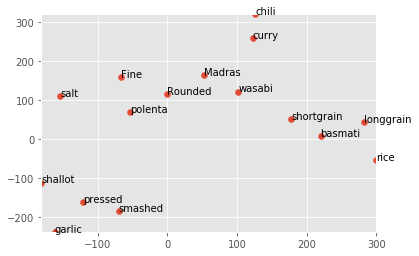

['salt', 'rice', 'garlic', 'curry']

In [61]:
#Scatterplot for words3 and 3 most similar words each
display_closestwords_tsnescatterplot(wordVector, words3,3)
words3